In [44]:
import torch
import torch.nn as nn
from tqdm import tqdm

from utils import Config, set_random_seed
from dataset import get_dataset, train_test_split, RIIIDDataset
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, accuracy_score
from model import SaintPlusTransformer

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

set_random_seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
config = Config('config.yaml')
config.__dict__

{'PATH_TO_TRAIN': 'data/train.csv',
 'PATH_TO_QUESTIONS': 'data/questions.csv',
 'TR_FRAC': 0.8,
 'MAX_LEN': 100,
 'BATCH_SIZE': 64,
 'QUESTION_VOCAB_SIZE': 13523,
 'ANSWER_CORR_VOCAB_SIZE': 2,
 'PART_VOCAB_SIZE': 7,
 'TIME_LAG_VOCAB_SIZE': 1441,
 'EMBED_SIZE': 128,
 'HIDDEN_SIZE': 512,
 'DROPOUT': 0.1,
 'HEADS': 8,
 'LAYERS': 1}

In [3]:
data = get_dataset(config)
tr_data, va_data = train_test_split(data=data, config=config)

tr_data = RIIIDDataset(dataset=tr_data, config=config)
va_data = RIIIDDataset(dataset=va_data, config=config)

tr_dataloader = DataLoader(dataset=tr_data, batch_size=config.BATCH_SIZE, shuffle=True)
va_dataloader = DataLoader(dataset=va_data, batch_size=config.BATCH_SIZE, shuffle=True)

In [4]:
# tr_data.__getitem__(1234)

In [5]:
# for tr_batch in tqdm(tr_dataloader):
#     pass

# Train

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SaintPlusTransformer(
    question_vocab_size    = config.QUESTION_VOCAB_SIZE + 1,
    answer_corr_vocab_size = config.ANSWER_CORR_VOCAB_SIZE + 1,
    part_vocab_size        = config.PART_VOCAB_SIZE + 1,
    time_lag_vocab_size    = config.TIME_LAG_VOCAB_SIZE + 1,
    max_len                = config.MAX_LEN - 1,
    embed_size             = config.EMBED_SIZE,
    hidden_size            = config.HIDDEN_SIZE,
    dropout                = config.DROPOUT,
    heads                  = config.HEADS,
    N                      = config.LAYERS
).to(device)

In [37]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4, eps=1e-9)
loss_fn = nn.CrossEntropyLoss(ignore_index=0).to(device)

for epoch in range(1):

    # TRAIN
    # -----
    
    tr_true = []
    tr_pred_label = []
    tr_pred_probs = []

    torch.cuda.empty_cache()
    model.train()
    batch_iterator = tqdm(tr_dataloader, desc=f"Processing Epoch {epoch:02d}")
    for tr_batch in batch_iterator:
        
        # enc
        ex = tr_batch['ex'].to(device)
        ep = tr_batch['ep'].to(device)

        # dec
        ac = tr_batch['ac'].to(device) 
        tl = tr_batch['tl'].to(device) 

        # label
        label = tr_batch['label'].to(device).long()

        # masks
        src_mask = tr_batch['src_mask'].to(device)
        tgt_mask = tr_batch['tgt_mask'].to(device)

        preds = model(
            src=ex, 
            tgt=ac,
            src_mask=src_mask, 
            tgt_mask=tgt_mask,
            part=ep,
            time_lag=tl,
        )
        
        _, pred_labels = torch.max(preds[:,-1], dim=1)
        pred_probs = torch.softmax(preds[:,-1][:,1:3], dim=-1)
        
        loss = loss_fn(
            target=label.view(-1), # (batch_size * max_len)
            input=preds.view(-1, config.ANSWER_CORR_VOCAB_SIZE + 1), # (batch_size * max_len, vocab_size)
        )

        batch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})

        # backpropagate the loss
        loss.backward()

        # update the weights
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        
        tr_true.extend(label[:,-1].cpu().detach().numpy())
        tr_pred_label.extend(pred_labels.cpu().detach().numpy())
        tr_pred_probs.extend(pred_probs[:,1].cpu().detach().numpy())
    
    # VALIDATION
    # ----------

    va_true = []
    va_pred_label = []
    va_pred_probs = []

    model.eval()
    with torch.no_grad():
        for va_batch in tqdm(va_dataloader):

            # enc
            ex = va_batch['ex'].to(device)
            ep = va_batch['ep'].to(device)

            # dec
            ac = va_batch['ac'].to(device) 
            tl = va_batch['tl'].to(device) 

            # label
            label = va_batch['label'].to(device).long()

            # masks
            src_mask = va_batch['src_mask'].to(device)
            tgt_mask = va_batch['tgt_mask'].to(device)

            preds = model(
                src=ex, 
                tgt=ac,
                src_mask=src_mask, 
                tgt_mask=tgt_mask,
                part=ep,
                time_lag=tl,
            )

            _, pred_labels = torch.max(preds[:,-1], dim=1)
            pred_probs = torch.softmax(preds[:,-1][:,1:3], dim=-1)

            va_true.extend(label[:,-1].cpu().detach().numpy())
            va_pred_label.extend(pred_labels.cpu().detach().numpy())
            va_pred_probs.extend(pred_probs[:,1].cpu().detach().numpy())

    print(f'TR ACC: {accuracy_score(tr_true, tr_pred_label):.4f} TR AUC: {roc_auc_score(tr_true, tr_pred_probs):.4f}')
    print(f'VA ACC: {accuracy_score(va_true, va_pred_label):.4f} VA AUC: {roc_auc_score(va_true, va_pred_probs):.4f}')
    print()

100%|██████████| 14/14 [00:02<00:00,  5.31it/s]

TR ACC: 0.5375 TR AUC: 0.5766
VA ACC: 0.6026 VA AUC: 0.6538



# Let's look at the attention scores

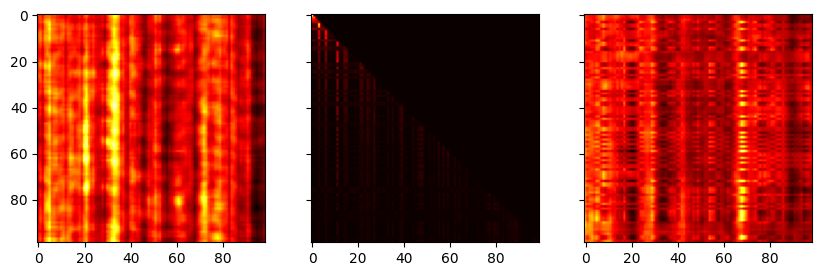

In [109]:
layer = 0 # what layer to select (0, config.LAYERS) 
example = 2 # what sequence to select (0, config.BATCH_SIZE) 
head = 7 # what head to select (0, config.HEADS) 

enc_self_att = model.encoder.layers[layer].self_attention_block.attention_scores[example, head]
dec_self_att = model.decoder.layers[layer].self_attention_block.attention_scores[example, head]
dec_cross_att = model.decoder.layers[layer].cross_attention_block.attention_scores[example, head]

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(10,5))
axes[0].imshow(enc_self_att, cmap='hot')
axes[1].imshow(dec_self_att, cmap='hot')
axes[2].imshow(dec_cross_att, cmap='hot');